In [1]:
# This file runs logistic regression with original imbalanced data "cleaned_K8.csv"
# It first performs PCA to check how many principle components are needed for 90% and 95% of the variability of the data
# It runs the logistic regression implemented by us and by sklearn 

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import eig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("cleaned_K8.csv", header = None, low_memory = False)  # process the data with pandas

In [3]:
# Take a peek at the data:

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.006,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007,0
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,0
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.019,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,0
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.051,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049,0
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,0


In [5]:
# get the X and y from the data

In [6]:
feature_cols = [x for x in range(5408)]
X = df[feature_cols]
y = df[5408]
print("dimensions of X", X.shape)

dimensions of X (16592, 5408)


In [11]:
# perform PCA on X, finding PCs that explains "percent" of data
# Output: X_reduced, X with reduced dimension
def PCA_X(X, percent):
    feature_cols = [x for x in range(5408)]     # store the features by their indexes
    feature_cols_np = np.array(feature_cols)

    mean_center_X = X - np.mean(X, axis = 0)    # get the mean centered X from X

    # calculate the covar_matrix
    covar_matrix = mean_center_X.T @ mean_center_X / (len(mean_center_X) - 1)

    # perform eigendecomposition, getting eig_val and eig_vector
    eig_val, eig_vector = eig(covar_matrix)
    

    # sort through eigen_val, creating "indexes"
    sorted_indexes = eig_val.argsort()[::-1][:len(eig_val)]
    eig_val = eig_val[sorted_indexes]

    eig_vector = eig_vector[:,sorted_indexes]   # sort the eig_vector based on sorted_indexes
    feature_cols_np = feature_cols_np[sorted_indexes] # sort the feature_cols based on sorted_indexes

    sum_eig = sum(eig_val)                      # sum over all eig_val for determining percent of variability

    # up toward what number of principle components does "percent" of data's variability get explained
    count = 0
    sum_eig_sofar = 0
    for i in range(len(eig_val)):
        if sum_eig_sofar < (percent * sum_eig):
            sum_eig_sofar += eig_val[i]
            count += 1

    print("Amount of principle components that explains", percent*100, "%:", count)

    # get eig_vectors that explains "percent" of data
    eig_vector_reduced = eig_vector[:, 0:count]
    
    # get X_reduced by projecting each data point in X to the M dimensions described by M eigenvectors
    # Note: M here is the amount of eigenvectors that explains "percent" of data
    X_reduced = mean_center_X @ eig_vector_reduced
    return X_reduced


In [12]:
X_reduced = PCA_X(X, 0.90)
X_reduced = PCA_X(X, 0.95)


Amount of principle components that explains 90.0 %: 48
Amount of principle components that explains 95.0 %: 127


In [19]:
class LogisticRegressionHand:
    def __init__(self, learn_rate = 0.001, num_iters=10000):
        self.learn_rate = learn_rate
        self.num_iters = num_iters
        self.W = None 
        self.bias = None
    
    # X is num_samples by num_features 
    # y is 1D row vector for each training sample
    def fit(self, X, y):
        # init params (as zeros)
        num_samples, num_features = X.shape
        self.W = np.zeros(num_features)
        self.bias = 0
        #print("num_samples, num_features", num_samples, num_features)
        #print("self.W.shape", self.W.shape)
        
        # gradient descent
        for i in range(self.num_iters):
            linear_model = np.dot(X, self.W) + self.bias 
            
            y_predicted = self._sigmoid(linear_model)
            
            # derivatives
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)
            
            # update weights and bias 
            self.W -= self.learn_rate * dw
            self.bias -= self.learn_rate * db
            
    def predict(self, X):
        linear_model = np.dot(X, self.W) + self.bias 
        y_predicted = self._sigmoid(linear_model)
        
        # based on y_predicted, get the predicted class label
        y_predicted_label = [1 if i > 0.5 else 0 for i in y_predicted]
        
        return y_predicted_label
    
    # sigmoid func
    def _sigmoid(self, x):
        sigmoid = 1 / (1 + np.exp(-x))
        return sigmoid

In [20]:
# a function to calculate accuracy 
def accuracy(y_observed, y_predicted):
    accuracy = np.sum(y_observed == y_predicted) / len(y_observed)
    return accuracy

In [21]:
def LogisticRegression_package(X, y, testSize):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 1234)
    clf = LogisticRegression(max_iter = 10000)
    clf.fit(X_train, y_train)
    
    y_predictions = clf.predict(X_test)
    print("")
    print("For SMOTE + RandomUnderSampler with LR from sklearn package:")
    print("Logistic classification accurary:", accuracy(y_test, y_predictions))
    print("precision_score", precision_score(y_test, y_predictions))
    print("recall_score", recall_score(y_test, y_predictions))
    print("f1_score", f1_score(y_test, y_predictions))
    print("roc_auc_score", roc_auc_score(y_test, y_predictions))
    
    cm = confusion_matrix(y_test, y_predictions)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [22]:
# Hyper-parameter, parameter: testSize, 
def LogisticRegression_calc(X, y, testSize):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 1234)
    
    Logistic_regressor = LogisticRegressionHand(learn_rate = 0.001, num_iters=10000)
    Logistic_regressor.fit(X_train, y_train)
    y_predictions = Logistic_regressor.predict(X_test)
    print("")
    print("For SMOTE + RandomUnderSampler with hand-implemented LR:")
    print("Logistic classification accurary:", accuracy(y_test, y_predictions))
    print("precision_score", precision_score(y_test, y_predictions))
    print("recall_score", recall_score(y_test, y_predictions))
    print("f1_score", f1_score(y_test, y_predictions))
    print("roc_auc_score", roc_auc_score(y_test, y_predictions))
    
    cm = confusion_matrix(y_test, y_predictions)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()
    


For SMOTE + RandomUnderSampler with hand-implemented LR:
Logistic classification accurary: 0.9929690638810768
precision_score 0.7894736842105263
recall_score 0.32608695652173914
f1_score 0.46153846153846156
roc_auc_score 0.6626379632568145


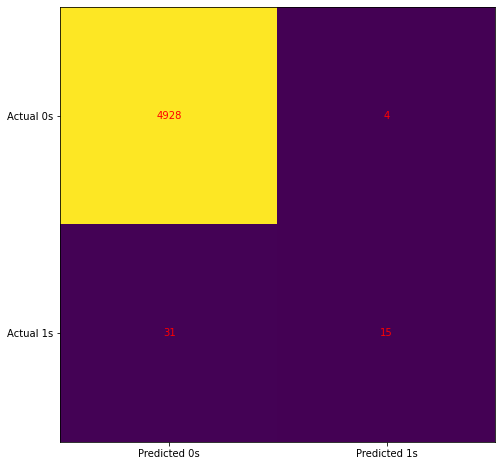

In [23]:
# logistic regression on original data 
LogisticRegression_calc(X, y, 0.3)


For SMOTE + RandomUnderSampler with LR from sklearn package:
Logistic classification accurary: 0.9889513860988349
precision_score 0.42105263157894735
recall_score 0.5217391304347826
f1_score 0.46601941747572817
roc_auc_score 0.7575240664339363


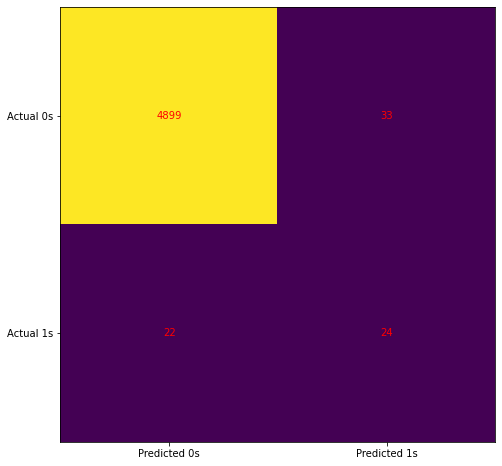

In [24]:
# use sklearn package 
LogisticRegression_package(X, y, 0.3)